In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *

### Simulation Settings

In [2]:
# Highest Fock state
nMax = 200 

# Size of Wigner function to plot (set to match the plots from the paper)
xvec = np.linspace(-3, 3, 200)
pvec = np.linspace(-2, 12, 200)

# QuTip integration settings
options = Options()
options.num_cpus = 5
options.nsteps = 100000

# Solution given in paper
pulse_seq = [-0.353282, 0.902028, -0.518804, 
            -0.447977, 0.447404, 0.231963,
            -0.307409, -0.191352, 0.354135,
            0.141061, -0.544457, -0.310069,
            0.685625, 0.623302, -0.144266,
            -0.808851, -0.102101, -0.682909,
            1.021610, 0.534188, -0.54781]

# The time for each displacement pulse
pulse_time = 0.5 

### Ideal Cubic Phase Gate

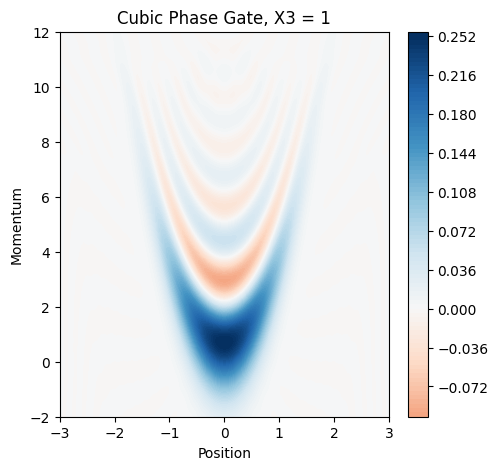

In [3]:
ideal_x = position(nMax) # Position Operator
ideal_H = - ideal_x**3 # Cubic Phase Operator

ideal_psi0 = basis(nMax) # Initialise in |n=0> state

ideal_output = mesolve(H = ideal_H, rho0 = ideal_psi0, tlist = [0.0, 1.0], options = options)
ideal_rho = ideal_output.states[-1]
ideal_W = wigner(ideal_rho, xvec, pvec)

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
im = ax.contourf(xvec, pvec, ideal_W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Cubic Phase Gate, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

In [4]:
# -------------------- Define Operators -------------------- #
a = tensor(qeye(2), destroy(nMax))
x = tensor(qeye(2), position(nMax))

sX = tensor(sigmax(), qeye(nMax))
sY = tensor(sigmay(), qeye(nMax))
sZ = tensor(sigmaz(), qeye(nMax))
sM = tensor(destroy(2), qeye(nMax))

### Ideal Rabi Gates (Pauli-Z Controlled Displacement, Pauli-Y Angles)

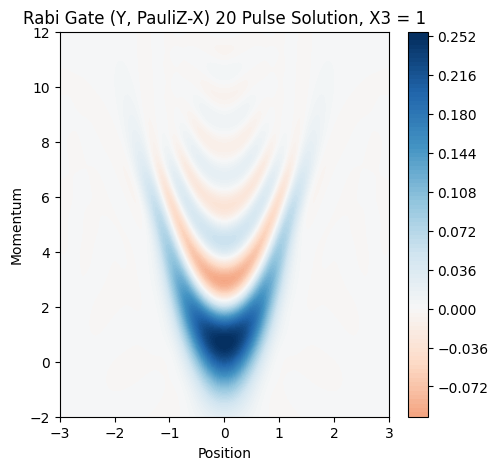

In [5]:
# -------------------- Pulse Function -------------------- #
def pulse_Y_CZ(initial_state, angle, pulse_time, init = False):
    """
    Action of each pulse, for Y carrier rotations + Ctrl-Z displacements
    """
    H1 = angle * sY
    H2 = pulse_time * sZ * x
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H2, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H1, rho0 = rho1, tlist = [0.0, 1.0], options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
initial_state = tensor(basis(2,0), basis(nMax, 0))

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho = pulse_Y_CZ(initial_state = initial_state, angle = i, pulse_time = pulse_time, init = True)
        
    else:
        rho = pulse_Y_CZ(initial_state = rho, angle = i, pulse_time = pulse_time, init = False)
        
rho_Y_CZ = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1] # Final displacement to bring state to origin
motion_Y_CZ = ptrace(rho_Y_CZ, 1) # Trace out spin component
wigner_Y_CZ = wigner(motion_Y_CZ, xvec, pvec)   
# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
im = ax.contourf(xvec, pvec, wigner_Y_CZ, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Rabi Gate (Y, PauliZ-X) 20 Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

### Ideal Rabi Gates (Pauli-X Controlled Displacement, Pauli-Y Angles)

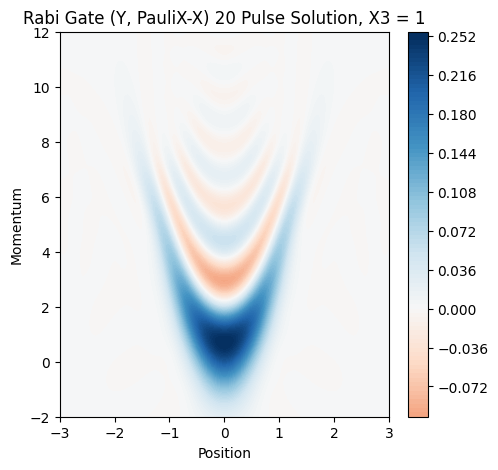

In [6]:
# -------------------- Pulse Function -------------------- #
def pulse_Y_CX(initial_state, angle, pulse_time, init = False):
    """
    Action of each pulse, for Y carrier rotations + Ctrl-Z displacements
    
        track-state: List to keep track of system density matrix per step
    """
    H1 = angle * sY
    H2 = pulse_time * sX * x # Note conditional on Pauli-X now.
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H2, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H1, rho0 = rho1, tlist = [0.0, 1.0], options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
# Begin in + state since conditional-PauliX displacement
initial_state = tensor((basis(2,0) + basis(2,1)), basis(nMax, 0)) 

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho  = pulse_Y_CX(initial_state = initial_state,angle = i, pulse_time = pulse_time, init = True)
        
    else:
        rho = pulse_Y_CX(initial_state = rho, angle = i, pulse_time = pulse_time, init = False)
        
rho_Y_CX = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
motion_Y_CX = ptrace(rho_Y_CX, 1)

wigner_Y_CX = wigner(motion_Y_CX, xvec, pvec)   
# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
#ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
#ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, wigner_Y_CX, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Rabi Gate (Y, PauliX-X) 20 Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

### Ideal Rabi Gates (Pauli-Y Controlled Displacement, Pauli-X Angles)

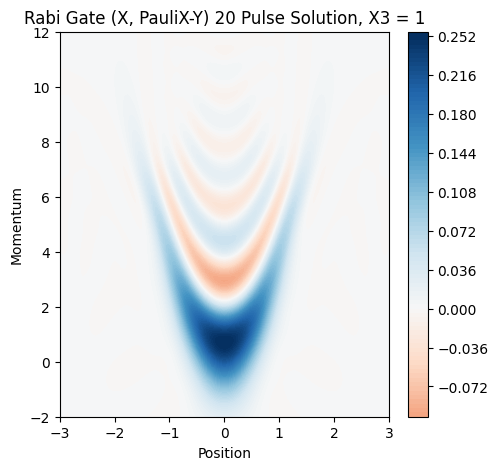

In [7]:
# -------------------- Pulse Function -------------------- #
def pulse_X_CY(initial_state, angle, pulse_time, init = False):
    """
    Action of each pulse, for Y carrier rotations + Ctrl-Z displacements
    
        track-state: List to keep track of system density matrix per step
    """
    H1 = angle * sX
    H2 = pulse_time * sY * x
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H2, rho0 = initial_state, tlist = [0.0, 1.0], options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H1, rho0 = rho1, tlist = [0.0, 1.0], options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
# Begin in + state since conditional-PauliX displacement
initial_state = tensor((basis(2,0) + 1j *basis(2,1)), basis(nMax, 0)) 

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho  = pulse_X_CY(initial_state = initial_state,angle = i, pulse_time = pulse_time, init = True)
        
    else:
        rho = pulse_X_CY(initial_state = rho, angle = i, pulse_time = pulse_time, init = False)
        
rho_X_CY = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
motion_X_CY = ptrace(rho_X_CY, 1)

wigner_X_CY = wigner(motion_X_CY, xvec, pvec)   
# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
#ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
#ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, wigner_X_CY, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Rabi Gate (X, PauliX-Y) 20 Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

### Lamb-Dicke Regime Trapped Ion Hamiltonian

Text(0, 0.5, 'Momentum')

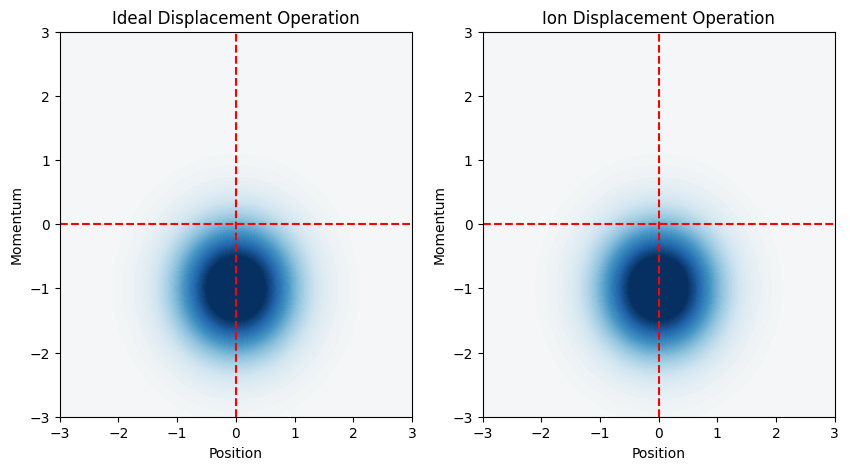

In [8]:
detuning = 0
omega = 1/np.sqrt(2)

# -------------------- Setup Operators -------------------- #
rsb = a * sM.dag()
def rsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['rsb_detuning'] * t)

rsbp = a.dag() * sM 
def rsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['rsb_detuning'] * t)

bsb = a.dag() * sM.dag()
def bsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['bsb_detuning'] * t)

bsbp = a * sM
def bsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['bsb_detuning'] * t)

args = {"omega": omega, "rsb_detuning": detuning, "bsb_detuning": -detuning, "rsb_phase": 0, "bsb_phase": 0}

ion_displace = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

# -------------------- Verify Above Hamiltonian is Correct -------------------- #
# Change plot range on Wigner so that it's easier to see
xxvec = np.linspace(-3, 3, 200)
ppvec = np.linspace(-3, 3, 200)

# Ideal Position Operator
initial_state = tensor(basis(2,0), basis(nMax, 0))
output = mesolve(H = x, rho0 = initial_state, tlist = [0.0, 1.0], options = options).states[-1]
ideal = ptrace(output, 1)
ideal_w = wigner(ideal, xxvec, ppvec)

# Trapped Ion Position Operator
initial_state = tensor(basis(2,0) + basis(2,1), basis(nMax, 0))

output = mesolve(H = ion_displace, rho0 = initial_state, tlist = [0.0, 1.0], args = args).states[-1]
motion = ptrace(output, 1)
w = wigner(motion, xxvec, ppvec)

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

for i in range(len(ax)):
    ax[i].vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
    ax[i].hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')

im = ax[0].contourf(xxvec, ppvec, ideal_w, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax[0].set_title("Ideal Displacement Operation")
ax[0].set_xlabel("Position")
ax[0].set_ylabel("Momentum")

im = ax[1].contourf(xxvec, ppvec, w, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax[1].set_title("Ion Displacement Operation")
ax[1].set_xlabel("Position")
ax[1].set_ylabel("Momentum")

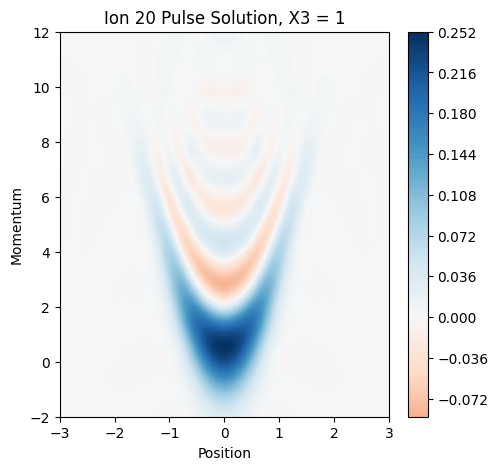

In [20]:
# -------------------- Pulse Function -------------------- #
def pulse_ion(initial_state, angle, pulse_time, detuning, init = False):
    """
    Action of each pulse, for Y carrier rotations + Ctrl-Z displacements
    
        track-state: List to keep track of system density matrix per step
    """
    H1 = angle * sY
    H2 = ion_displace
    args["bsb_detuning"] = -detuning
    args["rsb_detuning"] = detuning
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], args = args, options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], args = args, options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H2, rho0 = rho1, tlist = [0.0, pulse_time], args = args, options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
# Begin in +i state since conditional-PauliY displacement
initial_state = tensor((basis(2,0) + basis(2,1)), basis(nMax, 0)) 

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = 0, init = True)
        
    else:
        rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = 0, init = False)
    
rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
motion_ion = ptrace(rho_ion, 1)

wigner_ion = wigner(motion_ion, xvec, pvec)   

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
#ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
#ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, wigner_ion, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Ion 20 Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

#### Allowing for Detuning Fluctuations

In [21]:
""" initial_state = tensor((basis(2,0) + basis(2,1)), basis(nMax, 0)) 
res = []

for k in range(100):
    scale = 5
    detuning = 2 * scale * ( np.random.rand() - 1/2 )

    for i in pulse_seq: # Iterative Evolution over rho
        if i == pulse_seq[0]: # Initial pulse
            rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = detuning, init = True)
            
        else:
            rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = detuning, init = False)
        
    rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
    motion_ion = ptrace(rho_ion, 1)

    wigner_ion = wigner(motion_ion, xvec, pvec)  
    
    res.append(wigner_ion) 
    
# -------------------- Plot Results -------------------- #  
w = np.mean(res, axis = 0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
#ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
#ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, w, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Detuning Range = pm100Hz")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1) """

' initial_state = tensor((basis(2,0) + basis(2,1)), basis(nMax, 0)) \nres = []\n\nfor k in range(100):\n    scale = 5\n    detuning = 2 * scale * ( np.random.rand() - 1/2 )\n\n    for i in pulse_seq: # Iterative Evolution over rho\n        if i == pulse_seq[0]: # Initial pulse\n            rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = detuning, init = True)\n            \n        else:\n            rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = detuning, init = False)\n        \n    rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]\n    motion_ion = ptrace(rho_ion, 1)\n\n    wigner_ion = wigner(motion_ion, xvec, pvec)  \n    \n    res.append(wigner_ion) \n    \n# -------------------- Plot Results -------------------- #  \nw = np.mean(res, axis = 0)\n\nfig, ax = plt.subplots(1, 1, figsize=(5, 5))\n\n# Lines to show center of Wigner Function (just for convenience

#### Allowing for Angle Errors

In [22]:
""" initial_state = tensor((basis(2,0) + 1j * basis(2,1)), basis(nMax, 0)) 
res = []

for k in range(100):
    for i in pulse_seq: # Iterative Evolution over rho
        
        i = i + (i/100) * ((np.random.rand() - 1/2)) * 2
        
        if i == pulse_seq[0]: # Initial pulse
            rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = detuning, init = True)
            
        else:
            rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = detuning, init = False)
        
    rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
    motion_ion = ptrace(rho_ion, 1)

    wigner_ion = wigner(motion_ion, xvec, pvec)  
    
    res.append(wigner_ion) 
    
# -------------------- Plot Results -------------------- #  
w = np.mean(res, axis = 0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
#ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
#ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, w, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Angle Error = 1%")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1) """

' initial_state = tensor((basis(2,0) + 1j * basis(2,1)), basis(nMax, 0)) \nres = []\n\nfor k in range(100):\n    for i in pulse_seq: # Iterative Evolution over rho\n        \n        i = i + (i/100) * ((np.random.rand() - 1/2)) * 2\n        \n        if i == pulse_seq[0]: # Initial pulse\n            rho  = pulse_ion(initial_state = initial_state,angle = i, pulse_time = pulse_time, detuning = detuning, init = True)\n            \n        else:\n            rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, detuning = detuning, init = False)\n        \n    rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]\n    motion_ion = ptrace(rho_ion, 1)\n\n    wigner_ion = wigner(motion_ion, xvec, pvec)  \n    \n    res.append(wigner_ion) \n    \n# -------------------- Plot Results -------------------- #  \nw = np.mean(res, axis = 0)\n\nfig, ax = plt.subplots(1, 1, figsize=(5, 5))\n\n# Lines to show center of Wigner Function (just for 

# KMY's Actual Contribution

In [23]:
%reset -f

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qutip import *

options = Options()
options.num_cpus = 5
options.nsteps = 100000

from gen_cubic_phase_sequence import generate_cubic_sequence as generator

pulse_time = 1.0

pulse_number = 11
displacement = 7.0

pulse_seq = generator(pulse_time, pulse_number, displacement)

Optimization terminated successfully.
For Displacement =  7.0
Solution for Optimal Angles:  [-0.13899619  0.60525266 -1.1676682   0.97015134 -0.66250171  1.07702374
 -1.07701478  0.66248932 -0.97012822  1.16765171 -0.60526051  0.13900241]
Calculated infidelity:  0.061 



In [24]:
# Highest Fock state
nMax = 100

xvec = np.linspace(-3, 3, 200)
pvec = np.linspace(-3, 12, 200)

# -------------------- Define Operators -------------------- #
a = tensor(qeye(2), destroy(nMax))
x = tensor(qeye(2), position(nMax))

sX = tensor(sigmax(), qeye(nMax))
sY = tensor(sigmay(), qeye(nMax))
sZ = tensor(sigmaz(), qeye(nMax))
sM = tensor(destroy(2), qeye(nMax))

# -------------------- Setup Operators -------------------- #
detuning = 0
omega = 1/np.sqrt(2)

rsb = a * sM.dag()
def rsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['rsb_phase']) * np.exp(-1j * args['rsb_detuning'] * t)

rsbp = a.dag() * sM 
def rsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['rsb_phase']) * np.exp(1j * args['rsb_detuning'] * t)

bsb = a.dag() * sM.dag()
def bsb_coeff(t, args):
    return args['omega'] * np.exp(1j * args['bsb_phase']) * np.exp(-1j * args['bsb_detuning'] * t)

bsbp = a * sM
def bsbp_coeff(t, args):
    return args['omega'] * np.exp(-1j * args['bsb_phase']) * np.exp(1j * args['bsb_detuning'] * t)

args = {"omega": omega, "rsb_detuning": detuning, "bsb_detuning": -detuning, "rsb_phase": 0, "bsb_phase": 0}

ion_displace = [
    [rsb, rsb_coeff], [rsbp, rsbp_coeff], [bsb, bsb_coeff], [bsbp, bsbp_coeff]
]

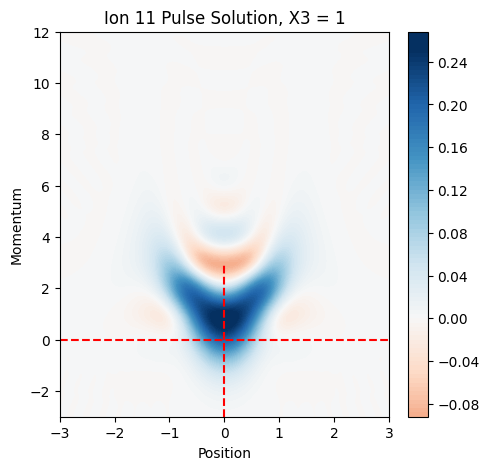

In [25]:
# -------------------- Pulse Function -------------------- #
def pulse_ion(initial_state, angle, pulse_time, init = False):
    H1 = angle * sY
    H2 = ion_displace
    
    if init == True: # Initial (phi_0) carrier rotation
        output = mesolve(H = H1, rho0 = initial_state, tlist = [0.0, 1.0], args = args, options = options)
        rho1 = output.states[-1]
        
        return rho1

    else: # All other terms -> The terms in brackets in equation above
        output = mesolve(H = H2, rho0 = initial_state, tlist = [0.0, 1.0], args = args, options = options)
        rho1 = output.states[-1]
        
        output2 = mesolve(H = H1, rho0 = rho1, tlist = [0.0, pulse_time], args = args, options = options)
        rho2 = output2.states[-1]
        
        return rho2
    
# Begin in + state since conditional-PauliX displacement
initial_state = tensor((basis(2,0) + basis(2,1)), basis(nMax, 0)) 

for i in pulse_seq: # Iterative Evolution over rho
    if i == pulse_seq[0]: # Initial pulse
        rho  = pulse_ion(initial_state = initial_state, angle = i, pulse_time = pulse_time, init = True)
        
    else:
        rho = pulse_ion(initial_state = rho, angle = i, pulse_time = pulse_time, init = False)
        
rho_ion = mesolve(H = -7 * x, rho0 = rho, tlist = [0.0, 1.0], options = options).states[-1]
motion_ion = ptrace(rho_ion, 1)

wigner_ion = wigner(motion_ion, xvec, pvec)  

# -------------------- Plot Results -------------------- #
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Lines to show center of Wigner Function (just for convenience)
ax.vlines(0, ymin = -3, ymax = 3, colors = 'r', linestyles = 'dashed')
ax.hlines(0, xmin = -3, xmax = 3, colors = 'r', linestyles = 'dashed')
    
im = ax.contourf(xvec, pvec, wigner_ion, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
ax.set_title("Ion " + str(pulse_number) + " Pulse Solution, X3 = 1")
ax.set_xlabel("Position")
ax.set_ylabel("Momentum")

fig.colorbar(im, ax=ax, fraction=.1)

In [ ]:
""" # For plotting
radius = np.linspace(0.001, 3.0, 101)
radius = [i for i in radius]

theta = np.linspace(offset_phase, offset_phase + 2 * np.pi, 101)
theta = [i for i in theta]

# For plotting & Storing Data
theta_array = [theta for i in range(len(radius))]
radius_array = [[radius[j] for i in range(len(theta))] for j in range(len(radius))]

nColumns = len(theta)
nRows = len(radius)

plot_data = np.zeros((nRows, nColumns))

# Plot settings
vmin = -1
vmax = 1
levels = 20
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Characteristic Function Simulation
initial_state = tensor(ket2dm(basis(2, 0)), motion_ion)

#psi1 = rot(0) * initial_state

res = []

for phase in theta:
    for amp in radius:
        args['rsb_phase'] = phase
        args['bsb_phase'] = -phase

        output = mesolve(H = push, rho0 = initial_state, tlist = [0, amp], args = args)
        state = output.states[-1]
        
        ion_state = ptrace(state, 0)
        proj = expect(sigmaz(), ion_state)

        res.append(proj) """

In [ ]:
""" counter = 0

for i in range(len(res)):
    if i > 1 and i % nRows == 0:
        counter += 1

    plot_data[i - counter * nRows][counter] = np.real(res[i])

fig, ax = plt.subplots(subplot_kw = dict(projection='polar'), figsize = (5, 5))
#ax.set_theta_zero_location("E")
#ax.set_theta_direction(1)

cax = ax.contourf(theta, radius, plot_data)
cbar = fig.colorbar(cax)
fig.suptitle("Real Part", size = 'xx-large') """